In [1]:
import numpy as np
from keras.datasets import cifar10
from random import randrange
import time

Using TensorFlow backend.
/home/andrey/anaconda3/envs/nn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from sklearn.model_selection import train_test_split

Подключим Tensorflow

In [3]:
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [6]:
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (50000, 32, 32, 3)
y_train (50000, 1)
x_test (10000, 32, 32, 3)
y_test (10000, 1)


In [7]:
x_train = x_train[:6500].copy()
y_train = y_train[:6500].copy()

In [8]:
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (6500, 32, 32, 3)
y_train (6500, 1)
x_test (10000, 32, 32, 3)
y_test (10000, 1)


Визуализируем классы

In [9]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

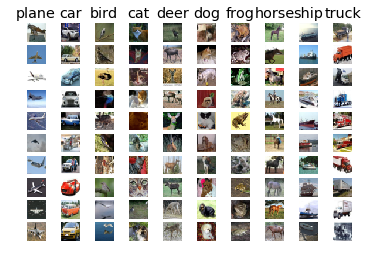

In [10]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

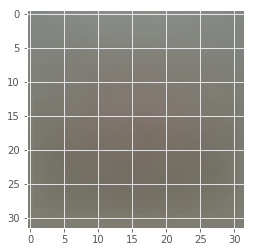

In [11]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [12]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000)

In [14]:
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_val', x_val.shape)
print('y_val', y_val.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (5500, 32, 32, 3)
y_train (5500,)
x_val (1000, 32, 32, 3)
y_val (1000,)
x_test (10000, 32, 32, 3)
y_test (10000,)


---

Попробуем решить задачу при помощи простой нейронной сети. Сначала объявим функцию, описывающую граф модели.

In [21]:
def build_simple_model():
    # placeholder'ы это точкb входа, можно восприпимать их, как аргументы функции, описываемой графом
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    
    #variable scope задаёт префикс для всех элементов внутри него
    #Это позволяет огранизовавывать структуру графа и вашего кода
    with tf.variable_scope("convolution_layer_1"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv1 = tf.get_variable("Wconv1", shape=[3, 3, 3, 32])
        bconv1 = tf.get_variable("bconv1", shape=[32])
        
        a1 = tf.nn.conv2d(x, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
        h1 = tf.nn.elu(a1)
        
    with tf.variable_scope("convolution_layer_2"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv2 = tf.get_variable("Wconv2", shape=[3, 3, 32, 64])
        bconv2 = tf.get_variable("bconv2", shape=[64])
        
        a2 = tf.nn.conv2d(h1, Wconv2, strides=[1,1,1,1], padding='VALID') + bconv2
        h2 = tf.nn.elu(a2)
        
    with tf.variable_scope("max_pooling_layer_1"):
        pool1 = tf.layers.max_pooling2d(inputs=h2, pool_size=[2, 2], strides=2)
        
    with tf.variable_scope("convolution_layer_3"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv3 = tf.get_variable("Wconv3", shape=[3, 3, 64, 128])
        bconv3 = tf.get_variable("bconv3", shape=[128])
        
        a3 = tf.nn.conv2d(pool1, Wconv3, strides=[1,1,1,1], padding='VALID') + bconv3
        h3 = tf.nn.elu(a3)
        
    with tf.variable_scope("convolution_layer_4"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv4 = tf.get_variable("Wconv4", shape=[3, 3,128, 128])
        bconv4 = tf.get_variable("bconv4", shape=[128])
        
        a4 = tf.nn.conv2d(h3, Wconv4, strides=[1,1,1,1], padding='VALID') + bconv4
        h4 = tf.nn.elu(a4)
    
    #добавляем полносвязные слои
    with tf.variable_scope("dense_layer_1"):
        W1 = tf.get_variable("W1", shape=[12800, 10000])
        b1 = tf.get_variable("b1", shape=[10000])
        
        flat = tf.reshape(h4,[-1,12800])
        linear_fc = tf.matmul(flat, W1) + b1
        fc1 = tf.nn.elu(linear_fc)
        
    with tf.variable_scope("dense_layer_2"):
        W2 = tf.get_variable("W2", shape=[10000, 10])
        b2 = tf.get_variable("b2", shape=[10])
        
        y_out = tf.matmul(fc1, W2) + b2
        
    # y_out -- это вектор оценок, которые генерирует модель. Теперь определим функцию потерь
    total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
    mean_loss = tf.reduce_mean(total_loss)
    
    correct_prediction = tf.equal(tf.argmax(y_out,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #Возвращаем те узлы графа, которые нам понадобятся в дальнейшем.
    #(x,y) это входы графа, а (y_out, mean_loss) выходы, которые представляют для нас интерес
    return (x,y), (y_out, mean_loss, accuracy)

Написанная выше функция не осуществляет никаких вычислений, единственное её предназначение -- описание графа.

In [22]:
#Перед вызовом функции очистим память от графов других моделей (актуально если вы вызываете эту ячейку повторно)
tf.reset_default_graph()
(x,y), (y_out, mean_loss, accuracy) = build_simple_model()

#Теперь зададим алгоритм оптимизации
optimizer = tf.train.AdamOptimizer(5e-5) 
#train_step -- специальный служебный узел в графе, отвечающий за обратный проход
train_step = optimizer.minimize(mean_loss) 

Пожалуйста, ознакомьтесь с другими возможностями, которые предоставляет tf для описания модели. 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

Теперь мы можем двигаться дальше и протестировать получившуюся модель. Для этого реализуем тренировочный цикл


In [23]:
def training_loop(session, model_inputs, model_outputs, train_step, summary_merge, writer, epochs=10, batch_size=64):
    
    #создаём индекс по всем объектам
    index = np.arange(len(x_train))
    
    #перемешиваем его
    np.random.shuffle(index)
    
    #разбиваем на батчи
    num_batches = int(len(index) / batch_size)
    batch_indexes = np.array_split(index, num_batches)
    
    #аналогично для теста
    index_test = np.arange(len(x_test))
    np.random.shuffle(index_test)
    num_batches_test = int(len(index_test) / batch_size)
    batch_indexes_test = np.array_split(index_test, num_batches_test)
    
    #аналогично для validation
    index_val = np.arange(len(x_val))
    np.random.shuffle(index_val)
    num_batches_val = int(len(index_val) / batch_size)
    batch_indexes_val = np.array_split(index_val, num_batches_val)
    
    
    x,y = model_inputs
    y_out, mean_loss, accuracy = model_outputs
    
    def train(x_values, y_values, batch_indexes, epoch):
        train_loses = []
        for i, batch_index in enumerate(batch_indexes):

            #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
            feed_dict = {x: x_values[batch_index],
                         y: y_values[batch_index]}

            #Здесь происходит непоследственный вызов модели
            #Обратите внимание, что мы передаём train_step
            scores, loss, acc, summary, _ = session.run(
                [y_out, mean_loss, accuracy, summary_merge, train_step],
                feed_dict=feed_dict)
            writer['train'].add_summary(summary, i + epoch*num_batches)
            
            train_loses.append(loss)
            print(f'iteration {i}, train loss: {loss:.3}, accuracy: {acc:.3}', end='\r')
            
        return train_loses
        
    def evaluate(x_values, y_values, batch_indexes, epoch):
        test_loses = []
        test_accuracy = []

        for batch_index in batch_indexes:

            #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
            feed_dict = {x: x_values[batch_index],
                         y: y_values[batch_index]}

            #Здесь происходит непоследственный вызов модели
            loss, acc, summary = session.run(
                [mean_loss, accuracy, summary_merge],
                feed_dict=feed_dict)
            writer['test'].add_summary(summary, i + epoch*num_batches_val)

            test_loses.append(loss)
            test_accuracy.append(acc)

        return test_loses, test_accuracy
    
    # цикл по эпохам
    for e in range(epochs):
        print(f'Epoch {e}:')
        train_loses = train(x_train, y_train, batch_indexes, e)
        val_loses, val_accuracy = evaluate(x_val, y_val, batch_indexes_val, e)
        print(f'train loss: {np.mean(train_loses):.3}, val loss: {np.mean(val_loses):.3}, accuracy: {np.mean(val_accuracy):.3}')
      
    print('================================================')
    print('Test set results:')
    test_loses, test_accuracy = evaluate(x_test, y_test, batch_indexes_test, e)
    print(f'test loss: {np.mean(test_loses):.3}, accuracy: {np.mean(test_accuracy):.3}')

In [24]:
# создаём сессию. Сессия -- это среда, в которой выполняются вычисления

with tf.Session() as sess:
    #мы можем явно указать устройство
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        #инициализируем веса, в этот момент происходит выделение памяти
        sess.run(tf.global_variables_initializer())
        
        # create a summary for our cost and accuracy
        tf.summary.scalar('Accuracy', accuracy)
        tf.summary.scalar('Cost', mean_loss)
        # merge all summaries into a single "operation" which we can execute in a session 
        summary = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter("train_output", sess.graph)
        test_writer = tf.summary.FileWriter("test_output")
        
        #запускаем тренировку
        training_loop(sess, model_inputs=(x,y), 
                      model_outputs=(y_out, mean_loss, accuracy), 
                      train_step=train_step,
                      summary_merge=summary,
                      writer={'train': train_writer, 'test': test_writer},
                      epochs=20)
        
#         # create a summary for our cost and accuracy
#         train_acc_scal = tf.summary.scalar('Train_Accuracy', accuracy)
#         train_cost_scal = tf.summary.scalar('Train_Cost', mean_loss)
#         # merge all summaries into a single "operation" which we can execute in a session 
#         summary_train = tf.summary.merge([train_acc_scal, train_cost_scal])
#         train_writer = tf.summary.FileWriter("output_train", sess.graph)
        
#         # create a summary for our cost and accuracy
#         test_acc_scal = tf.summary.scalar('Test_Accuracy', accuracy)
#         test_cost_scal = tf.summary.scalar('Test_Cost', mean_loss)
#         # merge all summaries into a single "operation" which we can execute in a session 
#         summary_test = tf.summary.merge([test_acc_scal, test_cost_scal])
#         test_writer = tf.summary.FileWriter("output_test", sess.graph)
        
#         #запускаем тренировку
#         training_loop(sess, model_inputs=(x,y), 
#                       model_outputs=(y_out, mean_loss, accuracy), 
#                       train_step=train_step,
#                       summary_merge={'train': summary_train,
#                                     'test': summary_test},
#                       writer={'train': train_writer,
#                               'test': test_writer},
#                       epochs=20)

Epoch 0:


KeyboardInterrupt: 

**Задача 1:** Модифицируйте предыдущий код так, чтобы данные о тренировке (train\val loss) выводились в tensorboard. Изучите визуализацию графа модели.

**Задача 2 (основная)** Реализуйте сеть, подобную [VGG-16](https://arxiv.org/pdf/1409.1556.pdf), для решения задачи. При реализации вам не разрешается пользоваться модулем **tf.layers** за исключением **tf.layers.batch_normalization** и **tf.layers.dropout**. Обратите внимание, что VGG-16 заточена под изображения большего разрешения.

![image.png](http://book.paddlepaddle.org/03.image_classification/image/vgg16.png)

Затем, после того, как сеть будет реализована постарайтесь получить масимально возможную точность, используя методы, описанные в лекциях (batch normalization, расписание learning rate, поменяйте функции активации, аугментация данных и т.д.). Результаты каждого слушателя затем будут занесены в таблицу и вывешены в репозитории курса.

Принимаются работы с точностью **не менее 73%**. 

Важно отметить, что с для улучшения результата, вы можете пойти дальше и изменить топологию сети. Например, использовать одну из представленных ниже 
  - [ResNets](https://arxiv.org/abs/1512.03385).
  - [DenseNets](https://arxiv.org/abs/1608.06993).
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

Напишите ваш код под текстом задания